In [1]:
import copy
import pickle

import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load result data 

In [21]:
# MODEL= "LB"
# RUN_ID = "2023-01-22T23:19:22.013087_LB"
# DAM_LOCS = ["L", "R"]

MODEL = "GH"
RUN_ID = "2023-02-05T19:45:04.032244_GH_0.05-step-delta"
DAM_LOCS = ["L_pier", "R_pier"]


all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S3,S4,S5,speed,x_dam,delta,L_abut,L_pier,R_pier,R_abut
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,10.85,NaN,NaN,23.0,17.733333,0.0,0.000138,0.000065,0.000062,0.000135
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,NaN,NaN,NaN,24.0,17.733333,0.0,0.000257,0.000116,0.000116,0.000246
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,NaN,NaN,NaN,28.0,17.733333,0.0,0.000117,0.000055,0.000055,0.000113
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,NaN,NaN,NaN,27.5,17.733333,0.0,0.000230,0.000097,0.000099,0.000221
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,NaN,NaN,NaN,25.5,17.733333,0.0,0.000120,0.000053,0.000053,0.000108


# Only keep columns we need to speed up computation

In [22]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,L_pier,R_pier
0,0.00,0,0,0,1,1,4,0.000065,0.000062
1,0.00,0,0,0,1,4,3,0.000116,0.000116
2,0.00,0,0,0,1,5,3,0.000055,0.000055
3,0.00,0,0,0,1,5,3,0.000097,0.000099
4,0.00,0,0,0,1,6,2,0.000053,0.000053
...,...,...,...,...,...,...,...,...,...
36701743,0.25,731,60,11,31,22,5,0.000055,0.000053
36701744,0.25,731,60,11,31,22,4,0.000084,0.000080
36701745,0.25,731,60,11,31,22,2,0.000035,0.000034
36701746,0.25,731,60,11,31,23,6,0.000093,0.000088


# Apply no sampling

In [4]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]


def calc_emd(df):
    return dict(
        zip(
            [l + "_" + n for n in AXLE_NAMES for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in AXLE_NUMS
                for l in DAM_LOCS
            ],
        )
    )

In [5]:
baseline = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

In [6]:
emd_vals = res_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
)
emd_samp_df = emd_df.dropna()

# Sample size

In [7]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]

for axles, n in zip(AXLE_NUMS, AXLE_NAMES):
    count_stats = (
        res_data.loc[(res_data.delta == 0) & res_data.AxleCount.isin(axles)]
        .groupby("year")
        .agg("count")
        .agg(["mean", "median", "std"])
        .iloc[:, 0]
    )
    print(
        n,
        f"\\num{{{count_stats.loc['mean']:.0f}}}\,(\\num{{{count_stats.loc['std']:.1f}}})",
    )

All \num{100278}\,(\num{437.2})
5ax \num{33993}\,(\num{243.5})
6ax \num{12524}\,(\num{132.0})


In [8]:
# Needed for stuff later on

In [9]:
delta_vals = res_data.delta.unique()
years = res_data.year.unique()[1:]  # remove baseline

# Plot Graphs

## Steps of Stairs

In [10]:
from importlib import reload

ajf_utils = reload(ajf_utils)

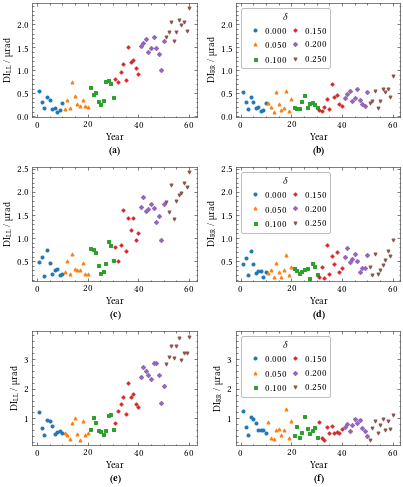

In [11]:
if MODEL == "LB":
    fig = ajf_utils.plot_steps_stairs(emd_samp_df, DAM_LOCS, years, delta_vals)
    ajf_plts.save_fig(fig, "figNoSamplingStepsStairs.pdf")
elif MODEL == "GH":
    fig = ajf_utils.plot_steps_stairs(
        emd_samp_df.filter(like="pier"), ["L_pier", "R_pier"], years, delta_vals
    )
    ajf_plts.save_fig(fig, "fig-GH-Piers-NoSamplingStepsStairs.pdf")

# Scatter all damage levels

In [12]:
from importlib import reload

ajf_utils = reload(ajf_utils)

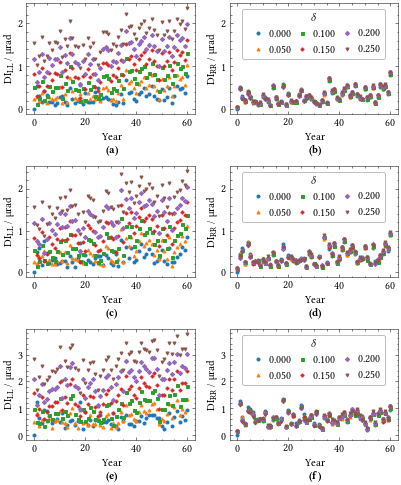

In [13]:
if MODEL == "LB":
    fig = ajf_utils.plot_scatter_all(emd_samp_df, DAM_LOCS)
    ajf_plts.save_fig(fig, "figNoSamplingScatter60years.pdf")
elif MODEL == "GH":
    # PIER
    fig = ajf_utils.plot_scatter_all(
        emd_samp_df.filter(like="pier"), ["L_pier", "R_pier"]
    )
    ajf_plts.save_fig(fig, "fig-GH-Pier-NoSamplingScatter60years.pdf")

# Load result data 

In [2]:
if MODEL == "LB":
    RUN_ID = "2023-01-29T12:51:27.214729_LB_0.02-step-delta"
    DAM_LOCS = ["L", "R"]

    all_data = (
        pd.read_parquet(f"./{RUN_ID}_w_error")
        .sort_values(["year", "delta"])
        .reset_index(drop=True)
    )

    all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S1,S2,S3,S4,S5,speed,x_dam,delta,L,R
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,3.75,9.60,10.85,NaN,NaN,23.0,11.333333,0.0,0.000089,0.000090
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,4.50,5.85,NaN,NaN,NaN,24.0,11.333333,0.0,0.000128,0.000125
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,5.20,6.55,NaN,NaN,NaN,28.0,11.333333,0.0,0.000062,0.000061
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,5.95,7.45,NaN,NaN,NaN,27.5,11.333333,0.0,0.000112,0.000113
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,6.05,NaN,NaN,NaN,NaN,25.5,11.333333,0.0,0.000062,0.000061


# Only keep columns we need to speed up computation

In [3]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,L,R
0,0.0,0,0,0,1,1,4,0.000089,0.000090
1,0.0,0,0,0,1,4,3,0.000128,0.000125
2,0.0,0,0,0,1,5,3,0.000062,0.000061
3,0.0,0,0,0,1,5,3,0.000112,0.000113
4,0.0,0,0,0,1,6,2,0.000062,0.000061
...,...,...,...,...,...,...,...,...,...
67286533,0.2,731,60,11,31,22,5,0.000095,0.000086
67286534,0.2,731,60,11,31,22,4,0.000158,0.000148
67286535,0.2,731,60,11,31,22,2,0.000047,0.000043
67286536,0.2,731,60,11,31,23,6,0.000153,0.000138


# Apply no sampling

In [23]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]


def calc_emd(df):
    return dict(
        zip(
            [l + "_" + n for n in AXLE_NAMES for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in AXLE_NUMS
                for l in DAM_LOCS
            ],
        )
    )

In [24]:
baseline = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

In [25]:
emd_vals = res_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
)
emd_samp_df = emd_df.dropna()
emd_samp_df *= 1e6  # convert to urad

## Prediction interval plots

In [26]:
from importlib import reload

ajf_utils = reload(ajf_utils)

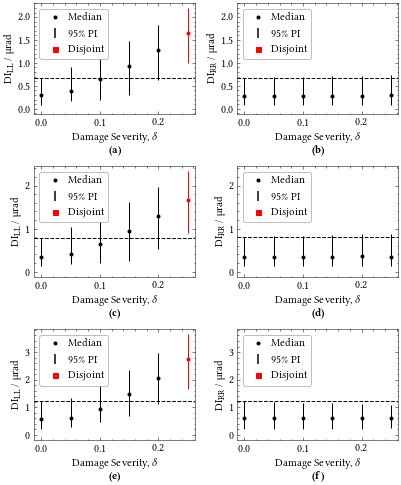

In [27]:
if MODEL == "LB":
    fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
    ajf_plts.save_fig(fig, "figNoSamplingPIPlots.pdf")
elif MODEL == "GH":
    # PIER
    fig = ajf_utils.plot_pi(
        emd_samp_df.filter(like="pier").reset_index(), ["L_pier", "R_pier"]
    )
    ajf_plts.save_fig(fig, "fig-GH-Pier-NoSamplingPIPlots.pdf")

# Table of Prediction Intervals

In [139]:
tab = ajf_utils.format_pred_int_table(emd_samp_df, DAM_LOCS)
with open("./output/tabNoSamplingPIs.tex", "w") as f:
    f.write(tab)
print(tab)

\begin{tabular}{lcccccc}

    \toprule
    {    } & \multicolumn{3}{c}{$\DI{LL}$ (\unit{\micro\radian})} & \multicolumn{3}{c}{$\DI{RR}$ (\unit{\micro\radian})}\\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7}
    $\delta$ & All &  5-axle & 6-axle &  All & 5-axle &  6-axle\\
    \midrule
    0.00 & (0.122, 0.892) & (0.199, 1.13) & (0.396, 1.73) & (0.117, 0.92) & (0.199, 1.16) & (0.421, 1.71)\\
0.02 & (0.225, 1.85) & (0.307, 2.27) & (0.776, 3.13) & (0.252, 1.3) & (0.288, 1.67) & (0.592, 2.19)\\
0.04 & \bfseries(1.12, 2.86) & \bfseries(1.3, 3.49) & \bfseries(2.09, 5.04) & (0.217, 1.74) & (0.32, 2.22) & (0.82, 3.02)\\
0.06 & \bfseries(2.11, 3.91) & \bfseries(2.54, 4.72) & \bfseries(4.0, 7.09) & (0.511, 2.18) & (0.658, 2.75) & (1.13, 3.79)\\
0.08 & \bfseries(3.18, 5.0) & \bfseries(3.8, 6.05) & \bfseries(6.04, 9.15) & \bfseries(0.938, 2.64) & \bfseries(1.18, 3.32) & \bfseries(1.84, 4.79)\\
0.10 & \bfseries(4.31, 6.15) & \bfseries(5.16, 7.43) & \bfseries(8.16, 11.3) & \bfseries(1.36, 3.15) & \bfse